In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

In [42]:
flight_data = sns.load_dataset("flights")
flight_data.head()
flight_data.shape

(144, 3)

In [4]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

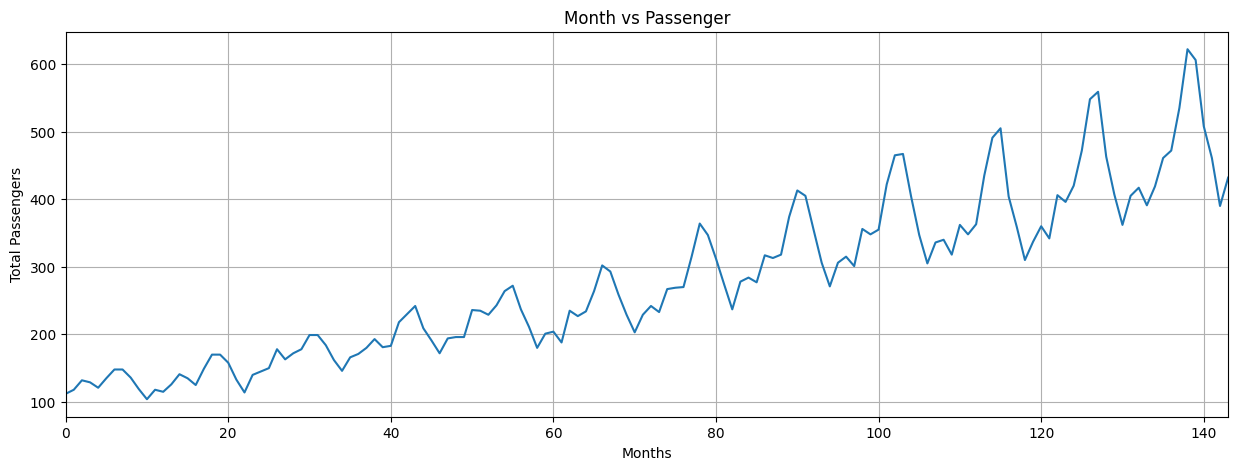

In [5]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

In [6]:
flight_data.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [7]:
all_data = flight_data['passengers'].values.astype(float)

In [8]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [9]:
print(len(train_data))
print(len(test_data))

132
12


In [10]:
print(test_data)

[417. 391. 419. 461. 472. 535. 622. 606. 508. 461. 390. 432.]


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [12]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]
[[1.        ]
 [0.57802198]
 [0.33186813]
 [0.13406593]
 [0.32307692]]


In [13]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized.shape

torch.Size([132])

In [14]:
train_window = 12

In [15]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [16]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
len(train_inout_seq)

120

In [17]:
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]),
  tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]),
  tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]),
  tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]),
  tensor([-0.9077]))]

In [18]:
torch.zeros(1,1,10)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [19]:
seq, label = train_inout_seq[0]
seq

tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385])

In [20]:
type(seq)

torch.Tensor

In [21]:
a=seq.view(len(seq), 1 , -1)  #-1 so that numbe rof elements in view matches the original numbe rof elements

In [22]:
b=torch.reshape(seq, (len(seq), 1,1 ))

In [23]:
class LSTM(nn.Module):
    #HIDDEN LAYER SIZE WAS 100 initially
    def __init__(self, input_size=1, hidden_layer_size=5, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
        #self.arr_sd =[]

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        #print ("LSTM: ", lstm_out)
       # lstm_out = lstm_out[:, -1]
        #print (lstm_out)
        #lstm_out_reshaped = lstm_out.view(len(input_seq), -1)  # convert to 2d
      #  print ("RESHAPED: ", lstm_out_reshaped[-1])
       # arr= lstm_out_reshaped.detach().numpy()
        #print(arr)
        #print()
       # sd = torch.std(lstm_out_reshaped)
        #arr_sd.append(sd)
        #lstm_df.to_csv("test.csv")
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
      #  print (predictions)
       # print (predictions[-1])
        return predictions[-1]

In [24]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
print(model)

LSTM(
  (lstm): LSTM(1, 5)
  (linear): Linear(in_features=5, out_features=1, bias=True)
)


In [60]:
epochs =150
loss=[]
epoch=[]
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
    #print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    loss.append(round(single_loss.item(), 8))
    epoch.append(i)
    #print()
    #if i%25 == 1:
    #    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

#print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

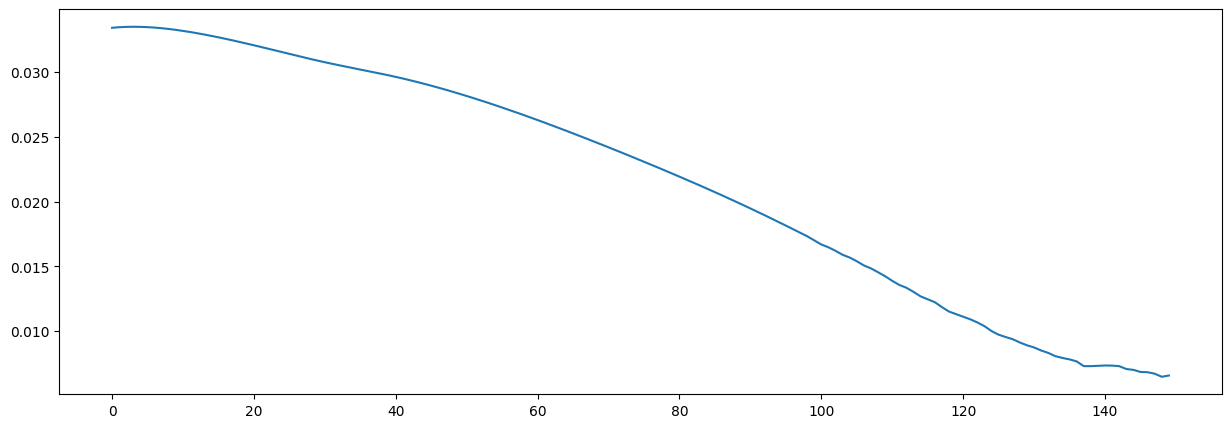

In [62]:
plt.plot(epoch, loss)

In [27]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [28]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [29]:
test_inputs[fut_pred:]

[0.31767165660858154,
 0.3131895065307617,
 0.31009766459465027,
 0.30780965089797974,
 0.30612239241600037,
 0.30485907196998596,
 0.3038969039916992,
 0.3031403124332428,
 0.30252566933631897,
 0.30211418867111206,
 0.3018704056739807,
 0.30174165964126587]

In [30]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[403.77030188]
 [402.75061274]
 [402.0472187 ]
 [401.52669558]
 [401.14284427]
 [400.85543887]
 [400.63654566]
 [400.46442108]
 [400.32458977]
 [400.23097792]
 [400.17551729]
 [400.14622757]]


In [31]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


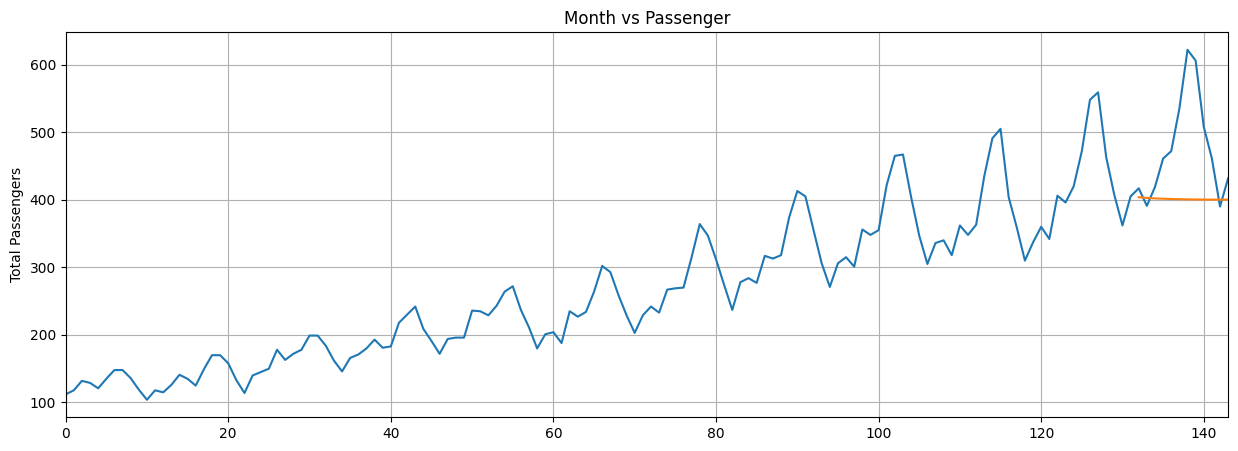

In [32]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

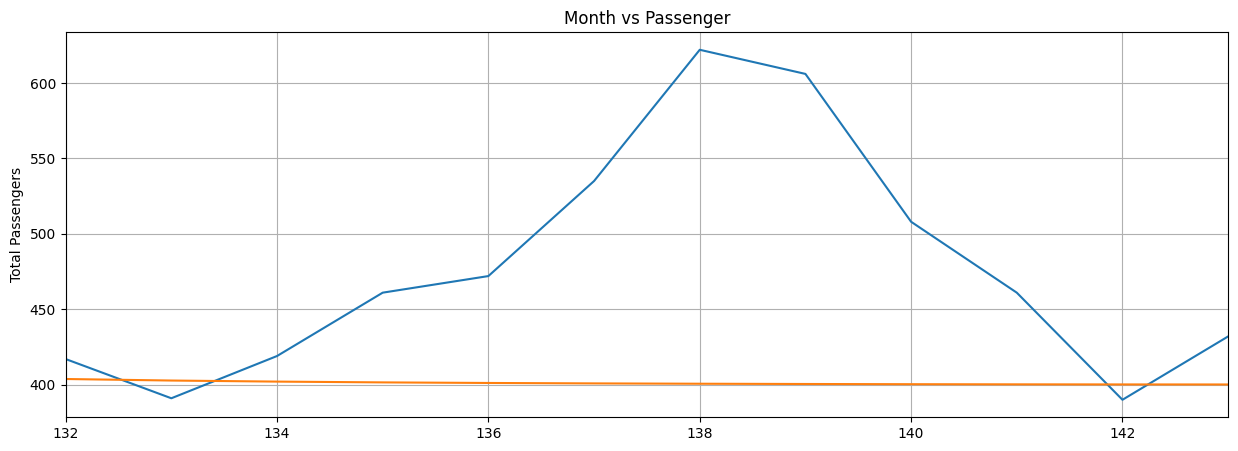

In [33]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()